# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
from typing import Callable
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter("ignore")



import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

root = pathlib.Path("/data")

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [4]:
%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [5]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)
    dt.summary(df)

Chewie 10-14-2016   
time signals:['pos', 'vel', 'acc', 'force', 'M1_spikes', 'PMd_spikes']  
M1_spikes units: 88  
PMd_spikes units: 190  
tasks in file: ['CO'], epochs: ['BL']  
Baseline trials: 770  

---


Mihili 03-03-2014   
time signals:['pos', 'vel', 'acc', 'force', 'M1_spikes', 'PMd_spikes']  
M1_spikes units: 51  
PMd_spikes units: 66  
tasks in file: ['CO'], epochs: ['AD' 'BL' 'WO']  
Baseline trials: 215  

---




preprocessing

In [6]:
def prep_general (df):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.combine_time_bins(df_, 3)
    
    if "M1_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
    if "PMd_spikes" in df_.columns:
        df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
        df_ = pyal.sqrt_transform_signal(df_, "PMd_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth')
    
    
    return df_


df_data_ready = [prep_general(df) for  df in df_data]

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-15, rel_end=1)
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', rel_start=-1, rel_end=15)

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


 the cell below does not correct for different number of units

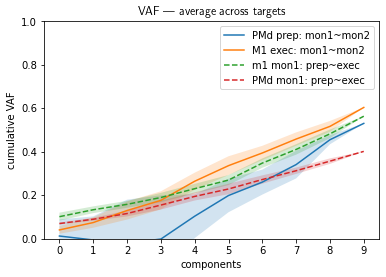

In [7]:
fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);

from the notes with Juan:
> to get an elbow: try same area, same monkey same target, different subsets of trials (the ideal easiest case)

Let's try the above, also as an upper bound for correlation and VAF


In [8]:
def VAF_half_trial_control(df1:pd.DataFrame, field1: str, epoch1, target1: int, n_components:int =10):
    """
    PCA on all the data, then dividing trials
    """
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)
    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');

    
    df1 = pyal.select_trials(df1, df1.target_id==target1)
    pca_1_target = np.concatenate(df1['_pca'].values, axis=0)
    
    # divide the matrix into 2
    n_samples = int(pca_1_target.shape[0]//2)
    pca_1_trial = pca_1_target[:n_samples,:]
    pca_2_trial = pca_1_target[-n_samples:,:]

    A, B, r, _, _ = dt.canoncorr(pca_1_trial, pca_2_trial, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_1, rates_1_C, B)
    
    return VAFs1, VAFs2, r


def VAF_half_trial_control(df1:pd.DataFrame, field1: str, epoch1, target1: int, n_components:int =10):
    """
    PCA on subset of trials
    """
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)
    n_samples = int(rates_1.shape[0]//2)

    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1[:n_samples,:])
    rates_1_C = rates_1_model.components_
    df1_ = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');
    df1_ = pyal.select_trials(df1_, df1_.target_id==target1)
    pca_1_target = np.concatenate(df1_['_pca'].values, axis=0)
    
    
    rates_2_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1[-n_samples:,:])
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df1, rates_2_model, field1, '_pca');
    df2 = pyal.select_trials(df2, df2.target_id==target1)
    pca_2_target = np.concatenate(df2['_pca'].values, axis=0)


    A, B, r, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1[:n_samples,:], rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_1[-n_samples:,:], rates_2_C, B)
    
    return VAFs1, VAFs2, r



def VAF_half_trial_control(df1:pd.DataFrame, field1: str, epoch1, target1: int, n_components:int =10):
    """
    PCA on all the data, then RANDOMising trials
    """
    rng = np.random.default_rng(12345)
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)
    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');

    
    df1 = pyal.select_trials(df1, df1.target_id==target1)
    all_id = df1.trial_id.to_numpy()
    rng.shuffle(all_id)
    n_samples = int(len(all_id)//2)
    # divide the matrix into 2
    df1_ = pyal.select_trials(df1, lambda trial: trial.trial_id in all_id[:n_samples])
    pca_1_target = np.concatenate(df1_['_pca'].values, axis=0)
    df1__ = pyal.select_trials(df1, lambda trial: trial.trial_id in all_id[-n_samples:])
    pca_2_target = np.concatenate(df1__['_pca'].values, axis=0)

    

    A, B, r, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_1, rates_1_C, B)
    
    return VAFs1, VAFs2, r

def VAF_half_trial_control(df1:pd.DataFrame, field1: str, epoch1, target1: int, n_components:int =10):
    """
    PCA on subset of trials, RANDOMising the subsets
    """
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
    
    rng = np.random.default_rng(12345)
    
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)

    all_id = df1.trial_id.to_numpy()
    rng.shuffle(all_id)
    n_samples = int(len(all_id)//2)
    # divide the matrix into 2
    
    df1_ = pyal.select_trials(df1, lambda trial: trial.trial_id in all_id[:n_samples])
    rates_1 = np.concatenate(df1_[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)

    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1_ = pyal.apply_dim_reduce_model(df1_, rates_1_model, field1, '_pca');
    df1_ = pyal.select_trials(df1_, df1_.target_id==target1)
    pca_1_target = np.concatenate(df1_['_pca'].values, axis=0)
    
    
    df2 = pyal.select_trials(df1, lambda trial: trial.trial_id in all_id[-n_samples:])
    rates_2 = np.concatenate(df2[field1].values, axis=0)
    rates_2 -= np.mean(rates_2,axis=0)

    
    rates_2_model = PCA(n_components=n_components, svd_solver='full').fit(rates_2)
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field1, '_pca');
    df2 = pyal.select_trials(df2, df2.target_id==target1)
    pca_2_target = np.concatenate(df2['_pca'].values, axis=0)

    n_samples = min ([pca_1_target.shape[0], pca_2_target.shape[0]])
    pca_1_target = pca_1_target[:n_samples,:]
    pca_2_target = pca_2_target[:n_samples,:]

    A, B, r, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_2, rates_2_C, B)
    
    return VAFs1, VAFs2, r

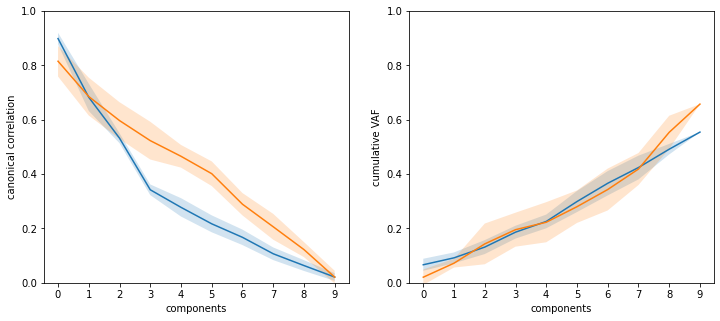

In [9]:
_,ax = plt.subplots(ncols=2, figsize=(12,5))
ax, ax2 = ax

for df in df_data_ready:
    VAFs1, VAFs2, Rs = [], [], []
    for target in range(8):
        # PMd prep: mon1~mon2
        v1, v2, r = VAF_half_trial_control(df, field1='M1_rates', epoch1=exec_epoch , target1= target)
        VAFs1.append(v1)
        VAFs2.append(v2)
        Rs.append(r)
        

    utility.shaded_errorbar(ax, np.array(Rs).T)
    utility.shaded_errorbar(ax2, np.cumsum(np.array(VAFs1).T, axis=0))
    
    ax.set_xlabel('components')
    ax.set_ylabel('canonical correlation')
    ax.set_ylim([0,1])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_xlabel('components')
    ax2.set_ylabel('cumulative VAF')
    ax2.set_ylim([0,1])
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

let's see what Juan thinks as per [here](https://github.com/AtMostafa/notebook/blob/main/meetings-with-juan/2021-07-22.mdhttps://github.com/AtMostafa/notebook/blob/main/meetings-with-juan/2021-07-22.md). **WHY** is it not different (higher CCs) compared to other across area/animal comparisons?

## Control

Compare it  with the NN paper, fig4 (M1 dynamics):  
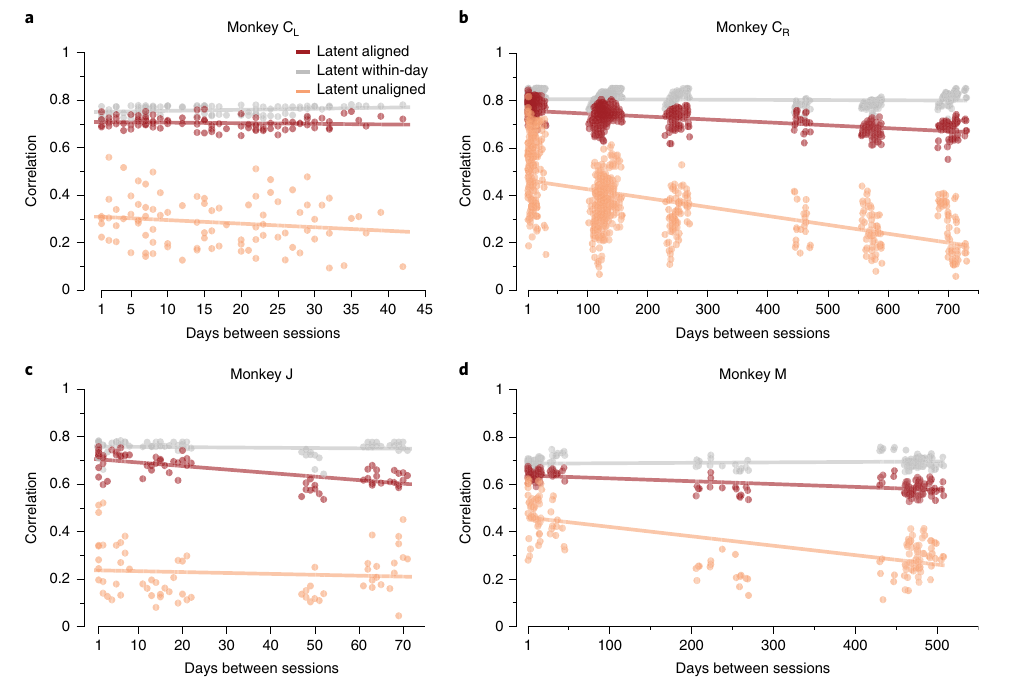  

### Details
- **animal**: $C_L$  is Chewie
- **window**: For *M1* it is $-120ms \sim +420ms$ and for *PMd* from $-390ms  \sim +60ms$
- **dim**: it is 10 for M1 and 15 for PMd
- **preprocessing**: 
    - remove firing rate below 1Hz overall
    - bin to 30ms
    - square root transform
    - smooth by Gaussian kernel, $\sigma=50ms$
    
Let's reproduce the gray dots: within-day CCs for one or two animals

In [38]:
ANIMAL = 'Chewie'
BIN_SIZE = .03  # sec
WINDOW_prep = (-.39, .06)  # sec
WINDOW_exec = (-.12, .42)  # sec

fileList = [root/ANIMAL/dataset for dataset in GoodDataList['M1'][ANIMAL]]


df_data_M1=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data_M1.append(df)
#     dt.summary(df)

In [39]:
def prep_general (df):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_ = pyal.remove_low_firing_neurons(df, "M1_spikes", 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_data_M1[0].bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    
    df_ = pyal.sqrt_transform_signal(df_, "M1_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


df_M1_ready = [prep_general(df) for  df in df_data_M1]

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [ ]:
def VAF_half_trial_control(df1:pd.DataFrame, field1: str, epoch1, target1: int, n_components:int =10):
    """
    PCA on all the data, then RANDOMising trials
    """
    rng = np.random.default_rng(12345)
    if "target_id" not in df1.columns:
        df1["target_id"] = df1.apply(get_target_id, axis=1)
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1 -= np.mean(rates_1,axis=0)
    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');

    
    df1 = pyal.select_trials(df1, df1.target_id==target1)
    all_id = df1.trial_id.to_numpy()
    rng.shuffle(all_id)
    n_samples = int(len(all_id)//2)
    # divide the matrix into 2
    df1_ = pyal.select_trials(df1, lambda trial: trial.trial_id in all_id[:n_samples])
    pca_1_target = np.concatenate(df1_['_pca'].values, axis=0)
    df1__ = pyal.select_trials(df1, lambda trial: trial.trial_id in all_id[-n_samples:])
    pca_2_target = np.concatenate(df1__['_pca'].values, axis=0)

    

    A, B, r, _, _ = dt.canoncorr(pca_1_target, pca_2_target, fullReturn=True)
    VAFs1 = dt.VAF_pc_cc(rates_1, rates_1_C, A)
    VAFs2 = dt.VAF_pc_cc(rates_1, rates_1_C, B)
    
    return VAFs1, VAFs2, r